In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
from glob import glob 
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split


Folder information about the spectrograms:
* classID:
A numeric identifier of the sound class:
* 0 = air_conditioner
* 1 = car_horn
* 2 = children_playing
* 3 = dog_bark
* 4 = drilling
* 5 = engine_idling
* 6 = gun_shot
* 7 = jackhammer
* 8 = siren
* 9 = street_music

In [3]:
#2. (Preprocessing) - Notebook
"""
Read the spectrograms - > Then grayscale transaction -> Resizing -> Normalisation.
"""
all_img_label = [] # The list for keeping img and label ->[img, label]
path = "./spectrograms"
folders = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
classes = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling',
           'gun_shot','jackhammer','siren','street_music']
# Function to load files and extract features
for folder in folders:
    for img_file in os.listdir(path+"/"+folder):
        if img_file.endswith('.png'):  
            img_path = path+"/"+folder+'/'+img_file
            all_img_label.append([img_path,classes[int(folder)]])
        



In [4]:
df = pd.DataFrame(all_img_label,columns =['img',"label"])
df 

,img,label
0,./spectrograms/0/100852-0-0-0.png,air_conditioner
1,./spectrograms/0/100852-0-0-1.png,air_conditioner
2,./spectrograms/0/100852-0-0-10.png,air_conditioner
3,./spectrograms/0/100852-0-0-11.png,air_conditioner
4,./spectrograms/0/100852-0-0-12.png,air_conditioner
...,...,...
8727,./spectrograms/9/99710-9-0-12.png,street_music
8728,./spectrograms/9/99710-9-0-16.png,street_music
8729,./spectrograms/9/99710-9-0-2.png,street_music
8730,./spectrograms/9/99710-9-0-5.png,street_music


In [7]:
# Create a dataframe for mapping label
df_labels = {
    'air_conditioner' : 0,
    'car_horn' : 1,
    'children_playing' : 2,
    'dog_bark' : 3,
    'drilling': 4,
    'engine_idling':5,
    'gun_shot':6,
    'jackhammer':7,
    'siren':8,
    'street_music':9,
    
}
# Encode
df['encode_label'] = df['label'].map(df_labels)

In [8]:
X = []
for img in df['img']:
    #grayscale
    img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
    #resize
    img = cv2.resize(img,(128, 128))
    #normalization
    img = img/255
    X.append(img)

In [9]:
y = df['encode_label']

In [12]:
"""c. X_train, y_train, X_val, y_val, X_test and y_test """
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)


In [13]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [14]:
X_train = X_train.reshape(-1,128,128,1)
X_test = X_test.reshape(-1,128,128,1)
X_val = X_val.reshape(-1,128,128,1)
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)
y_val = y_val.reshape(-1,)

In [15]:
#3. (Building and Training the model) - Notebook
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,Input
model = Sequential()
# Add a convolution and max pooling layer
model.add(Conv2D(32,kernel_size = (3,3),strides=(1,1),padding = "same",activation = "relu",input_shape=(128,128,1)))
model.add(MaxPooling2D((2,2)))
# Add more convolution and max pooling layers
model.add(Conv2D(64,kernel_size = (3,3),strides=(1,1),padding = "same",activation = "relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,kernel_size = (3,3),strides=(1,1),padding = "same",activation = "relu"))

# Flatten the convolution layer
model.add(Flatten())

# Add the dense layer and dropout layer
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

# Add the dense layer and dropout layer
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

# Add the output layer
model.add(Dense(10,activation="softmax"))

# Compile the model
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 32768)             0

In [16]:
results=model.fit(X_train,y_train,
                 batch_size=128,
                 epochs=50,validation_data=(X_val,y_val))

Epoch 1/50
52/52 [==============================] - 50s 941ms/step - loss: 2.0593 - accuracy: 0.2301 - val_loss: 1.7248 - val_accuracy: 0.4524
Epoch 2/50
52/52 [==============================] - 49s 946ms/step - loss: 1.7050 - accuracy: 0.3769 - val_loss: 1.3305 - val_accuracy: 0.5861
Epoch 3/50
52/52 [==============================] - 49s 945ms/step - loss: 1.4685 - accuracy: 0.4746 - val_loss: 1.0880 - val_accuracy: 0.6520
Epoch 4/50
52/52 [==============================] - 48s 922ms/step - loss: 1.2814 - accuracy: 0.5485 - val_loss: 1.0086 - val_accuracy: 0.6447
Epoch 5/50
52/52 [==============================] - 52s 1s/step - loss: 1.1490 - accuracy: 0.5833 - val_loss: 0.8389 - val_accuracy: 0.7473
Epoch 6/50
52/52 [==============================] - 53s 1s/step - loss: 1.0535 - accuracy: 0.6375 - val_loss: 0.8971 - val_accuracy: 0.7125
Epoch 7/50
52/52 [==============================] - 49s 936ms/step - loss: 0.9527 - accuracy: 0.6700 - val_loss: 0.7704 - val_accuracy: 0.7381
Epoch

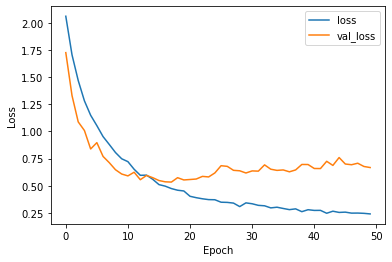

In [21]:
#4. (Visualizing data and model)
# Plot the the training loss
plt.plot(results.history["loss"],label="loss")

# Plot the the validation loss
plt.plot(results.history["val_loss"],label="val_loss")

# Name the x and y axises
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Put legend table
plt.legend()

# Show the plot
plt.show()



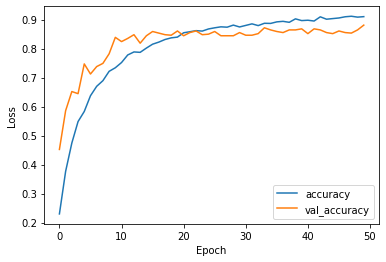

In [22]:
# Plot the the training accuracy
plt.plot(results.history["accuracy"],label="accuracy")

# Plot the the validation accuracy
plt.plot(results.history["val_accuracy"],label="val_accuracy")

# Name the x and y axises
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Put legend table
plt.legend()

# Show the plot
plt.show()


In [24]:
# Evaluate the performance
model.evaluate(X_test,y_test)


52/52 [==============================] - 3s 49ms/step - loss: 0.6092 - accuracy: 0.8894


[0.609165370464325, 0.889431893825531]